## Image Classification for the properties of a car i.e. car make, model and year 

In [1]:
# Import the libraries
import pandas as pd
import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import random
import torchvision
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
from torch import nn
import torch.nn.functional as F

In [2]:
# Create folder
def create_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
def save_train_data(fnames, labels, bboxes):
    src_folder ='../input/stanford-cars-dataset/cars_train/cars_train/'
    num_samples = len(fnames)
    # Select Train indices
    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)
    
    # Progress bar
    #pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')
    
    # The bounding box represents the boundaries of the car. 
    # The goal of this notebook is to build a model that recognizes a car and not object detection.
    # The reason for this is that in Customer Profile Verification, the user would be asked to
    # take a focused picture of the car and we would detect the car properties. Hence, object
    # detection is not required for this particular problem.
    
    for i in range(num_samples):
        # file and label
        fname = fnames[i]
        label = labels[i]
        
        # bounding box's top and bottom x, y coordinates
        (x1, y1, x2, y2) = bboxes[i]
        
        # image path, height and width
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        # 16 pixel margin for the outside the car bounding box
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        
        # Print the progress bar
        #pb.print_progress_bar((i + 1) * 100 / num_samples)
        
        # Destination folder paths for train and validation data
        if i in train_indexes:
            dst_folder = '/kaggle/working/data/train/'
        else:
            dst_folder = '/kaggle/working/data/valid/'
            
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        
        # Crop image according to the top and bottom x,y coordinates
        crop_image = src_image[y1:y2, x1:x2]
        
        # Resize the image
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [4]:
def save_test_data(fnames, bboxes):
    src_folder = '../input/stanford-cars-dataset/cars_test/cars_test/'
    dst_folder = '/kaggle/working/data/test/'
    num_samples = len(fnames)
    
    # Progress bar
    #pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        
        # file
        fname = fnames[i]
        
        # bounding box's top and bottom x, y coordinates
        (x1, y1, x2, y2) = bboxes[i]
        
        # image path, height and width
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        # 16 pixel margin for the outside the car bounding box
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        # Print the progress bar
        #pb.print_progress_bar((i + 1) * 100 / num_samples)
        
        # Destination folder paths for test data
        dst_path = os.path.join(dst_folder, fname)
        
        # Crop image according to the top and bottom x,y coordinates
        crop_image = src_image[y1:y2, x1:x2]
        
        # Resize the image
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [5]:
def process_train_data():
    print("Train data is being processed")
    
    # Load the train data label file
    cars_annos = scipy.io.loadmat('../input/cars-devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    # Initialize an empty list 
    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    # Store the file name, bounding box annotation and label id
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print('The number of car labels is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)

In [6]:
def process_test_data():
    print("Test data is being processed")
    
    # Load the test data label file
    cars_annos = scipy.io.loadmat('../input/cars-devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    # Initialize an empty list
    fnames = []
    bboxes = []
    
    # Store the file name and bounding box annotation
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)

In [7]:
# Image height and width
img_width, img_height = 224, 224

# Create three folders and store the train, test and validation data in those folders
create_folder('/kaggle/working/data/train')
create_folder('/kaggle/working/data/valid')
create_folder('/kaggle/working/data/test')

# Process train and test data
process_train_data()
process_test_data()

Train data is being processed
The number of car labels is 196
Test data is being processed


In [8]:
# Do data augmentation steps horizontal flip, lighting contrast, zoom, warp and random crop(probability=p)
tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])

# Load the data from folder, use batch size 64
data = ImageDataBunch.from_folder('data/','train','valid',
                                  ds_tfms=tfms
                                  ,size=128,bs=64).normalize(imagenet_stats)

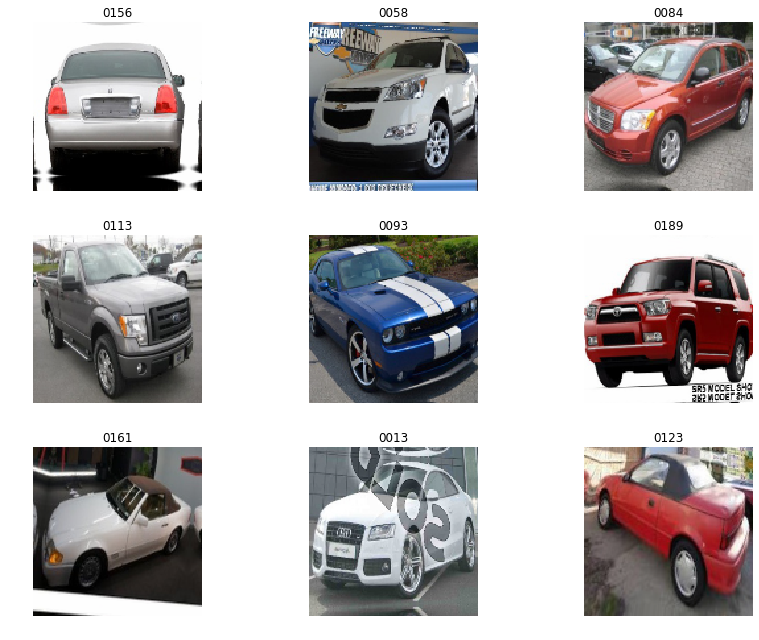

In [9]:
# Displaying few images
data.show_batch(rows=3, figsize=(12,9))

In [10]:
# Number of classes
data.c

196

In [11]:
from torch import nn
import torch.nn.functional as F

# Defining focal loss which deals with unbalanced data well
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [12]:
# Build a Resnet34 model pretrained on imagenet 
learn = cnn_learner(data, models.resnet34, 
                    metrics=[accuracy], model_dir=Path("/kaggle/working/"))
learn.loss_fn = FocalLoss()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 81074437.46it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02


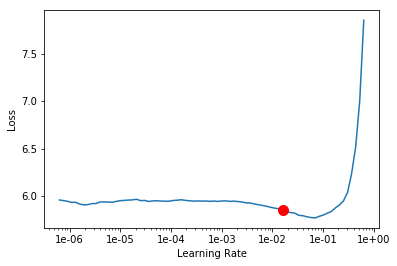

In [13]:
# Find the optimal learning rate and plot it
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
# Train the model for 40 epochs
learn.fit_one_cycle(40, max_lr=slice(2e-2), wd=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,5.412333,4.763303,0.066912,00:32
1,4.593015,4.071826,0.132597,00:32
2,3.877326,3.450913,0.212400,00:32
3,3.421411,3.059569,0.264580,00:32
4,3.153430,2.825907,0.310620,00:32
5,2.906193,2.634089,0.344997,00:32
6,2.714603,2.506494,0.375691,00:32
7,2.558758,2.388803,0.394721,00:32
8,2.462681,2.311534,0.419890,00:31
9,2.379426,2.222876,0.435850,00:32


In [15]:
# Save the model
learn.save('/kaggle/working/resnet_car_test40')

In [18]:
# Test the model on one image
img = open_image('../input/stanford-cars-dataset/cars_train/cars_train/00001.jpg')
pred_class,pred_idx,outputs = learn.predict(img)

In [19]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

0014


In [20]:
# Unfreeze the model and train again at a lower learning rate
learn.unfreeze();
learn = learn.clip_grad();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


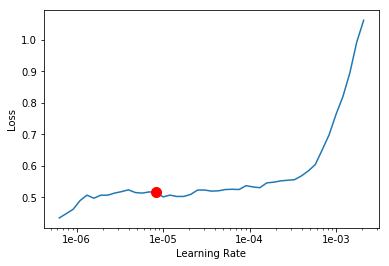

In [21]:
# Find a good learning rate 
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [24]:
# Load the model trained earlier and unfreeze its layer
learn.load('resnet_car_test40')
learn.unfreeze();
learn = learn.clip_grad();

In [25]:
# Use a gradually increasing learning rate i.e. a low learning rate at initial layers
# and a high learning rate at later layers.
lr = [3e-3/100, 3e-3/20, 3e-3/10]
#learn.fit_one_cycle(40, lr, wd=1e-7)
learn.fit_one_cycle(80, lr, wd=1e-7)


epoch,train_loss,valid_loss,accuracy,time
0,0.507850,1.163050,0.716390,00:34
1,0.488675,1.138641,0.713321,00:34
2,0.476674,1.124449,0.720074,00:35
3,0.474854,1.136419,0.716390,00:35
4,0.437697,1.119892,0.723143,00:35
5,0.445592,1.116851,0.712707,00:35
6,0.412687,1.101645,0.721301,00:35
7,0.433233,1.096882,0.724371,00:34
8,0.446390,1.072279,0.728668,00:35
9,0.453110,1.118593,0.726212,00:35


In [26]:
# The model has the validation accuracy of 0.84.
# Save this model as the final model
learn.save('resnet_car_final');